In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that will help the user with their query. Your task is just to recommend products to the user. You've been provided with product recommendation tool. Keep your answer concise.",
        ),
        ("human", "{input}"),
    ]
)

In [3]:
@tool
def product_recommendation(product_category: str) -> str:
    """
    Recommend products to the user based on product category.

    Args: 
        product_category (str): categories like "shirt", "jeans", etc.

    Returns:
        str: Recommended products in the given category.
    """
    recommendations = {
        "jeans": [
            "Slim Fit Blue Jeans",
            "Regular Fit Black Jeans",
            "Distressed Denim Jeans",
            "Tapered Fit Grey Jeans"
        ],
        "shirt": [
            "Classic White Oxford Shirt",
            "Casual Checked Shirt",
            "Formal Blue Slim Fit Shirt",
            "Denim Button-Down Shirt"
        ]
    }

    if product_category.lower() in recommendations:
        product_list = recommendations[product_category.lower()]
        return f"Here are some recommended {product_category}s: " + ", ".join(product_list)
    else:
        return f"Sorry, we don’t have recommendations for '{product_category}' yet."


In [4]:
model = ChatGoogleGenerativeAI(model = "gemini-2.5-flash", temperature = 0.1)

tools = [product_recommendation]
tool_node = ToolNode(tools)

model_chain = prompt | model.bind_tools(tools=tools)

In [5]:
def ask_gemini(state: MessagesState):
    messages = state["messages"]
    response = model_chain.invoke(messages)
    return {"messages": [response]}

def router(state: MessagesState):
    message = state["messages"]
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

workflow = StateGraph(MessagesState)

workflow.add_node("ask_gemini", ask_gemini)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "ask_gemini")
workflow.add_conditional_edges("ask_gemini", router, ["tools", END])
workflow.add_edge("tools", "ask_gemini")

graph_compile = workflow.compile()

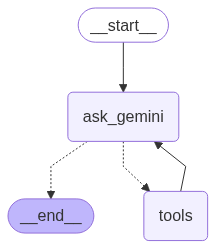

In [24]:
display(Image(graph_compile.get_graph().draw_mermaid_png()))

## Recommendation for Jeans

In [6]:
response = graph_compile.invoke({"messages": "can you recommend a jeans"})

In [7]:
response

{'messages': [HumanMessage(content='can you recommend a jeans', additional_kwargs={}, response_metadata={}, id='c8ecc55d-0524-43f6-80c1-5a75beb21682'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'product_recommendation', 'arguments': '{"product_category": "jeans"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--fcd6522e-c674-437c-8a53-0cc3f81b0b1d-0', tool_calls=[{'name': 'product_recommendation', 'args': {'product_category': 'jeans'}, 'id': 'a907a34f-2054-4fc6-98bf-002d1399468a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 182, 'output_tokens': 64, 'total_tokens': 246, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 45}}),
  ToolMessage(content='Here are some recommended jeanss: Slim Fit Blue Jeans, Regular Fit Black Jeans, Distressed Denim Jeans, Tapered Fit Grey Jeans', name='product_recom

In [8]:
response["messages"][-1].content

'Here are some recommended jeans: Slim Fit Blue Jeans, Regular Fit Black Jeans, Distressed Denim Jeans, Tapered Fit Grey Jeans.'

## Recommendation for Shirt

In [9]:
response = graph_compile.invoke({"messages": "can you recommend a shirt"})

In [10]:
response

{'messages': [HumanMessage(content='can you recommend a shirt', additional_kwargs={}, response_metadata={}, id='065f3716-4450-4028-bd6b-2b76718433c9'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'product_recommendation', 'arguments': '{"product_category": "shirt"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--53a5f7e9-07c8-4a91-8db2-64b4aca4e813-0', tool_calls=[{'name': 'product_recommendation', 'args': {'product_category': 'shirt'}, 'id': '18b861df-0ae6-4b36-b715-9363f08a8745', 'type': 'tool_call'}], usage_metadata={'input_tokens': 185, 'output_tokens': 98, 'total_tokens': 283, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 80}}),
  ToolMessage(content='Here are some recommended shirts: Classic White Oxford Shirt, Casual Checked Shirt, Formal Blue Slim Fit Shirt, Denim Button-Down Shirt', name='prod

In [11]:
response["messages"][-1].content

'Here are some recommended shirts: Classic White Oxford Shirt, Casual Checked Shirt, Formal Blue Slim Fit Shirt, Denim Button-Down Shirt.'

## Casual conversation

In [12]:
response = graph_compile.invoke({"messages": "Hello, what is machine learning?"})

In [13]:
response

{'messages': [HumanMessage(content='Hello, what is machine learning?', additional_kwargs={}, response_metadata={}, id='56a215d7-6667-4522-84f8-954ac4546b38'),
  AIMessage(content='I can only recommend products. What product category are you interested in?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--3ff03f6c-3e20-4e40-85b1-b665581cb73a-0', usage_metadata={'input_tokens': 186, 'output_tokens': 98, 'total_tokens': 284, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 84}})]}

In [14]:
response["messages"][-1].content

'I can only recommend products. What product category are you interested in?'

## Recommendation for Sherwani

In [21]:
response = graph_compile.invoke({"messages": "can you recommend a sherwani?"})

In [22]:
response

{'messages': [HumanMessage(content='can you recommend a sherwani?', additional_kwargs={}, response_metadata={}, id='8bffb5b2-6ba9-4bed-a1ef-1b31e007bc90'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'product_recommendation', 'arguments': '{"product_category": "sherwani"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--6f98f364-0d34-45be-9bf6-0d3c6215b37c-0', tool_calls=[{'name': 'product_recommendation', 'args': {'product_category': 'sherwani'}, 'id': '9af1d894-2ec5-4d32-8e36-ba033ff8a93d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 180, 'output_tokens': 78, 'total_tokens': 258, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 59}}),
  ToolMessage(content="Sorry, we don’t have recommendations for 'sherwani' yet.", name='product_recommendation', id='b7dc45f2-9280-4f14-bfa9-1ef98720f07e', tool_

In [23]:
response["messages"][-1].content

"Sorry, we don’t have recommendations for 'sherwani' yet."